Data fields
Each row of the training data contains a click record, with the following features.

ip: ip address of click.
app: app id for marketing.
device: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
os: os version id of user mobile phone
channel: channel id of mobile ad publisher
click_time: timestamp of click (UTC)
attributed_time: if user download the app for after clicking an ad, this is the time of the app download
is_attributed: the target that is to be predicted, indicating the app was downloaded
Note that ip, app, device, os, and channel are encoded.

The test data is similar, with the following differences:

click_id: reference for making predictions
is_attributed: not included

Soruce: https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/data

In [1]:
# Python 2 & 3 Compatibility
from __future__ import print_function, division

# Necessary imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve
from sklearn.cross_validation import train_test_split
from sklearn import svm
from sklearn.preprocessing import OneHotEncoder

import os
import pickle
from datetime import datetime
from dateutil.parser import parse

%matplotlib inline


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#make wider graphs
sns.set(rc={'figure.figsize':(12,5)});
plt.figure(figsize=(12,5));

In [3]:
with open("all_converted_data.pkl", 'rb') as picklefile: 
    df_new = pickle.load(picklefile)
df_new.shape


(1370538, 13)

In [4]:
df_new.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,hour,date,day,month,year
0,85010,3,1,19,280,2017-11-09 01:11:48,NaN,0,1,2017-11-09,9,11,2017
1,85329,3,1,70,424,2017-11-09 13:07:06,NaN,0,13,2017-11-09,9,11,2017
2,40436,9,1,19,466,2017-11-08 07:36:30,NaN,0,7,2017-11-08,8,11,2017
3,204367,3,1,6,205,2017-11-07 14:12:00,NaN,0,14,2017-11-07,7,11,2017
4,82927,1,1,19,13,2017-11-09 08:13:30,NaN,0,8,2017-11-09,9,11,2017


In [5]:
df_download = df_new[df_new.is_attributed == 1].sample(5000)
df_notDownload = df_new[df_new.is_attributed != 1].sample(5000*2)
df_all = df_notDownload.append(df_download, ignore_index=True)

In [6]:
df_all.shape

(15000, 13)

In [7]:
selectedFeatures=['ip', 'app', 'device', 'os', 'channel','hour']

In [8]:
df_all.dtypes

ip                       category
app                      category
device                   category
os                       category
channel                  category
click_time         datetime64[ns]
attributed_time            object
is_attributed               int64
hour                        int64
date                       object
day                         int64
month                       int64
year                        int64
dtype: object

In [9]:
X=df_all.loc[:, selectedFeatures]
y=df_all['is_attributed']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,random_state=42, stratify=y)


In [29]:
#code source: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [60]:
def printMetric(model, X_train_p, y_train_p, X_test_p, y_test_p, y_train_pred, y_pred):
    print("Test set Accuracy:     %.2f" % accuracy_score(y_train_p,y_train_pred))   
    print("------")
    print("Train set Accuracy:     %.2f" % accuracy_score(y_test_p,y_pred))
    print("F1:           %s" % f1_score(y_test_p, y_pred, average=None))
    print("F1(macro):    %.2f" % f1_score(y_test_p, y_pred, average='macro'))
    print("F1(weighted): %.2f" % f1_score(y_test_p, y_pred, average='weighted'))
    mat = confusion_matrix(y_test_p, y_pred)
    print(mat)
    
    # The random forest model by itself
    y_pred_rf = model.predict_proba(X_test_p)[:, 1]
    fpr_rf, tpr_rf, _ = roc_curve(y_test_p, y_pred_rf)
    plt.figure(2)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_rf, tpr_rf, label='RF')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    
    
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label');

In [31]:
def runSVC(X_train_p, y_train_p, X_test_p, y_test_p):
    from sklearn.svm import SVC
    model = SVC(probability=True)
    model.fit(X_train_p, y_train_p)
    y_train_pred = model.predict(X_train_p)
    y_pred = model.predict(X_test_p) 
    printMetric(model, X_train_p, y_train_p, X_test_p, y_test_p, y_train_pred, y_pred)

Test set Accuracy:     1.00
------
Train set Accuracy:     0.67
F1:           [0.80012802 0.00159872]
F1(macro):    0.40
F1(weighted): 0.53
[[5000    0]
 [2498    2]]


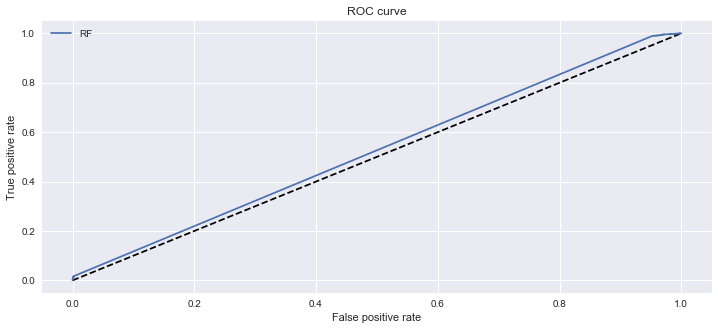

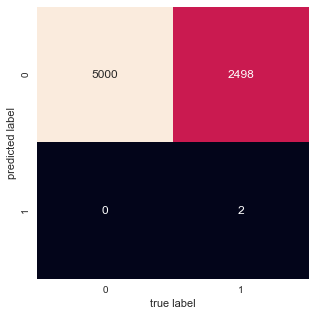

In [32]:
runSVC(X_train, y_train, X_test, y_test)

In [33]:
def runSVM(X_train_p, y_train_p, X_test_p, y_test_p):
    model = svm.SVC(probability = True)
    model.fit(X_train_p, y_train_p)
    y_train_pred = model.predict(X_train_p)
    y_pred = model.predict(X_test_p) 
    printMetric(model, X_train_p, y_train_p, X_test_p, y_test_p, y_train_pred, y_pred)

Attemp for other dataset from kaggle

Test set Accuracy:     1.00
------
Train set Accuracy:     0.67
F1:           [0.80012802 0.00159872]
F1(macro):    0.40
F1(weighted): 0.53
[[5000    0]
 [2498    2]]


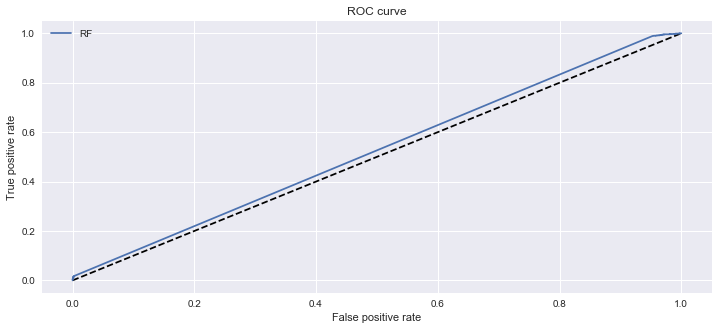

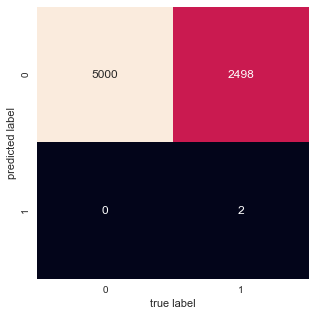

In [34]:
runSVM(X_train, y_train, X_test, y_test)

In [35]:
def runGaussianNB(X_train_p, y_train_p, X_test_p, y_test_p):
    from sklearn.naive_bayes import GaussianNB

    # Initialize our classifier
    model = GaussianNB()
    model.fit(X_train_p, y_train_p)
    y_train_pred = model.predict(X_train_p)
    y_pred = model.predict(X_test_p) 
    printMetric(model, X_train_p, y_train_p, X_test_p, y_test_p, y_train_pred, y_pred)

Test set Accuracy:     0.77
------
Train set Accuracy:     0.78
F1:           [0.84907198 0.57850822]
F1(macro):    0.71
F1(weighted): 0.76
[[4689  311]
 [1356 1144]]


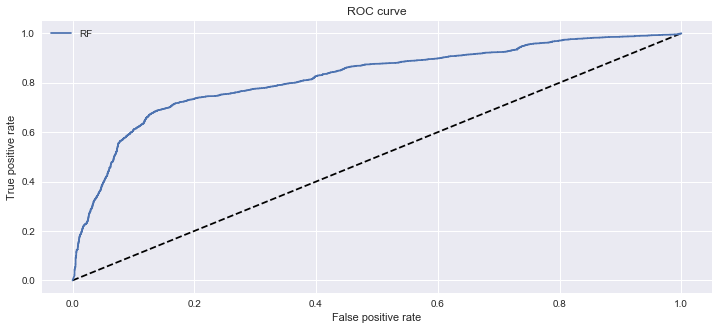

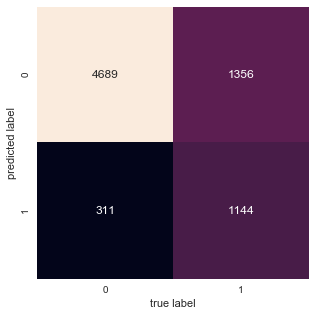

In [36]:
runGaussianNB(X_train, y_train, X_test, y_test)

In [37]:
def runLog(X_train_p, y_train_p, X_test_p, y_test_p):
    from sklearn.linear_model import LogisticRegression
    # Initialize our classifier
    model = LogisticRegression()
    model.fit(X_train_p, y_train_p)
    y_train_pred = model.predict(X_train_p)
    y_pred = model.predict(X_test_p) 
    printMetric(model, X_train_p, y_train_p, X_test_p, y_test_p, y_train_pred, y_pred)

Test set Accuracy:     0.78
------
Train set Accuracy:     0.77
F1:           [0.83610039 0.63405172]
F1(macro):    0.74
F1(weighted): 0.77
[[4331  669]
 [1029 1471]]


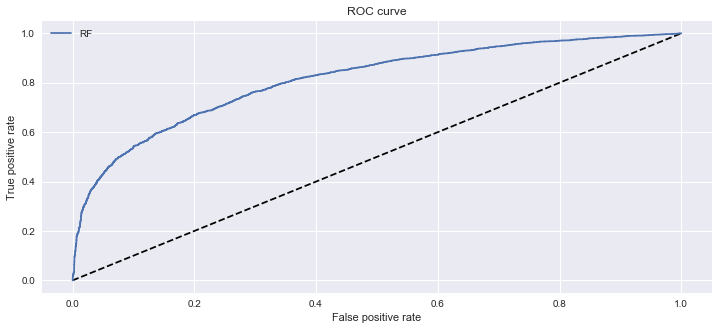

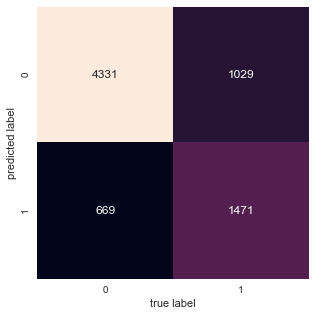

In [38]:
runLog(X_train, y_train, X_test, y_test)

In [47]:
def runRandom(X_train_p, y_train_p, X_test_p, y_test_p):
    from sklearn.ensemble import RandomForestClassifier    # Initialize our classifier
    model = RandomForestClassifier(random_state = 42)
    rf_enc = OneHotEncoder()
    model.fit(X_train_p, y_train_p)
    rf_enc.fit(model.apply(X_train_p))

    y_train_pred = model.predict(X_train_p)
    y_pred = model.predict(X_test_p) 


    
    printMetric(model, X_train_p, y_train_p, X_test_p, y_test_p, y_train_pred, y_pred)    
    base_accuracy = evaluate(model, X_test_p, y_test_p)
    print(base_accuracy)
   
    return model,base_accuracy

Test set Accuracy:     0.99
------
Train set Accuracy:     0.93
F1:           [0.94611943 0.88257736]
F1(macro):    0.91
F1(weighted): 0.92
[[4864  136]
 [ 418 2082]]


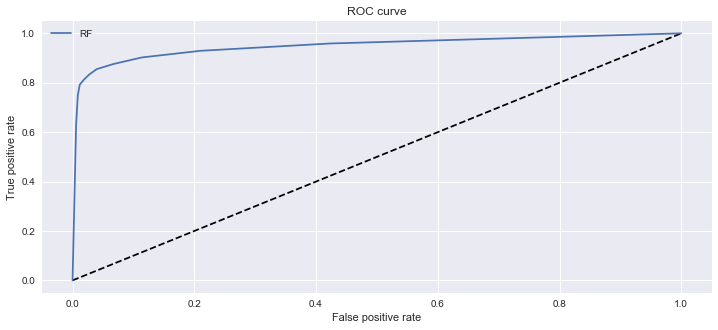

Model Performance
Average Error: 0.0739 degrees.
Accuracy = -inf%.
-inf


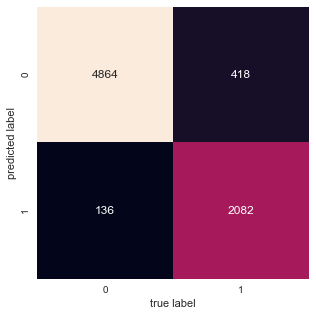

In [48]:
randForest_model,base_accuracy = runRandom(X_train, y_train, X_test, y_test)

In [41]:
#code source: https://jakevdp.github.io/PythonDataScienceHandbook/05.08-random-forests.html

In [42]:
#code source: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [56]:
def runRandomGrid(X_train_p, y_train_p, X_test_p, y_test_p, base_accuracy):
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import GridSearchCV
    param_grid = {
        'bootstrap': [True],
        'max_depth': [80, 90, 100, 110],
        'max_features': [2, 3],
        'min_samples_leaf': [3, 4, 5],
        'min_samples_split': [8, 10, 12],
        'n_estimators': [100, 200, 300, 1000]
    }
    model = RandomForestRegressor(random_state = 42)
    grid_search = GridSearchCV(estimator = model, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

    grid_search.fit(X_train_p, y_train_p)
    print(grid_search.best_params_)

    best_grid = grid_search.best_estimator_
    grid_accuracy = evaluate(best_grid, X_test_p, y_test_p)

    print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))


    
    #printMetric(model, X_train_p, y_train_p, X_test_p, y_test_p, y_train_pred, y_pred)    
    
   
    return model, grid_search.best_params_

In [57]:
randForest_model, best_fit_rf = runRandomGrid(X_train, y_train, X_test, y_test, base_accuracy)

Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_s

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.4s


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   7.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   2.4s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   2.4s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2

[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   2.3s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_

[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   7.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   1.5s
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   1.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   1.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=2

[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   9.0s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   1.8s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   1.8s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   9.0s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=3,

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.1min


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=   1.8s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   2.8s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   2.7s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   2.8s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_

[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   1.7s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   1.8s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   2.7s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   2.7s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_

[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   1.6s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   1.7s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   1.6s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total=   2.4s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_s

[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, total=   7.6s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=   1.5s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=   1.6s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=   1.5s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_

[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   1.6s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   1.6s
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total=   8.1s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_s

[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, total=   7.5s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, total=   7.5s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   1.8s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_

[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.6min


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   9.1s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   1.9s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   2.9s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   2.8s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=3

[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   2.0s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   2.0s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   2.2s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   2.9s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=

[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   9.7s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   2.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   2.4s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   2.4s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=3

[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   7.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   1.4s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   1.4s
[CV] bootstrap=True, max_depth=100, max_feat

[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   8.3s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   8.4s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   8.3s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_fea

[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   8.8s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   9.0s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_feat

[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   2.6s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.8s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_fea

[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   2.6s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   2.6s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_fea

[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   2.1s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   3.2s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   3.2s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   3.2s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_f

[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  4.9min


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=  10.9s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=  10.4s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   1.9s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_fea

[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   7.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.9s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.9s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   7.9s
[CV] bootstrap=True, max_depth=110, max_feat

[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.8s
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   7.9s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   8.4s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_fea

[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   2.4s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   7.8s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_feat

[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   2.8s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   2.9s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   2.8s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   1.0s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_fe

[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   1.9s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   2.8s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   2.9s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   2.8s
[CV] bootstrap=True, max_depth=110, max_f

[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   2.0s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   2.0s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   1.9s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   2.8s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_

[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  6.8min finished


{'bootstrap': True, 'max_depth': 80, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 200}
Model Performance
Average Error: 0.1179 degrees.
Accuracy = -inf%.
Improvement of nan%.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


{'bootstrap': True, 'max_depth': 100, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}

In [51]:
# best_fit_rf={'bootstrap': True, 'max_depth': 100, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 12, 'n_estimators': 100}

In [61]:
def runRandom_best(X_train_p, y_train_p, X_test_p, y_test_p):
    from sklearn.ensemble import RandomForestClassifier    # Initialize our classifier
    model = RandomForestClassifier(random_state = 42,**best_fit_rf)
    rf_enc = OneHotEncoder()
    model.fit(X_train_p, y_train_p)
    rf_enc.fit(model.apply(X_train_p))

    y_train_pred = model.predict(X_train_p)
    y_pred = model.predict(X_test_p) 


    
    printMetric(model, X_train_p, y_train_p, X_test_p, y_test_p, y_train_pred, y_pred)    
    base_accuracy = evaluate(model, X_test_p, y_test_p)
    print(base_accuracy)
   
    return model,base_accuracy

Test set Accuracy:     0.95
------
Train set Accuracy:     0.93
F1:           [0.95117225 0.89226165]
F1(macro):    0.92
F1(weighted): 0.93
[[4909   91]
 [ 413 2087]]


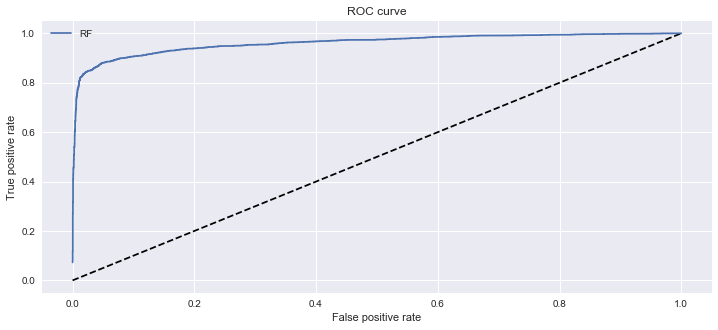

Model Performance
Average Error: 0.0672 degrees.
Accuracy = -inf%.
-inf


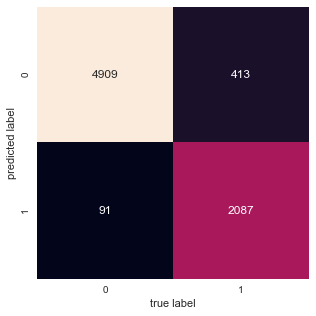

In [62]:
randForest_best_model,best_grid_accuracy = runRandom_best(X_train, y_train, X_test, y_test)